In [2]:
#!conda install -c conda-forge lightgbm
#!pip install optuna

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import sys
import os
import re
import random

from time import time
from tqdm import tqdm

from contextlib import contextmanager
import lightgbm as lgb
#import optuna.integration.lightgbm as opt_lgb

In [6]:
#上限表示数を拡張
pd.set_option('display.max_columns', 10000)
pd.set_option('display.max_rows', 200)

In [7]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

In [8]:
INPUT = "/content/drive/MyDrive/nishika/" # 所望のディレクトリに変更してください。
train_df = pd.read_csv(os.path.join(INPUT, "train.csv"))
test_df = pd.read_csv(os.path.join(INPUT, "test.csv"))
submission_df = pd.read_csv(os.path.join(INPUT, "sample_submission.csv"))

In [9]:
df_1_tr = pd.read_csv("/content/drive/MyDrive/nishika/output/train_SwinTransformerLarge384_V2Large256.csv")
df_1_ts = pd.read_csv("/content/drive/MyDrive/nishika/output/test_SwinTransformerLarge384_V2Large256.csv")

In [10]:
df_2_tr = pd.read_csv("/content/drive/MyDrive/nishika/output/train_efb2_rinnabase.csv")
df_2_ts = pd.read_csv("/content/drive/MyDrive/nishika/output/test_efb2_rinnabase.csv")

In [11]:
df_2_tr = df_2_tr.drop(df_2_tr.columns[0:352], axis=1)

In [12]:
df_2_ts = df_2_ts.drop(df_2_ts.columns[0:352], axis=1)

In [13]:
df_3_tr = pd.read_csv("/content/drive/MyDrive/nishika/output/train_swinv2base256_ginza510electra.csv")
df_3_ts = pd.read_csv("/content/drive/MyDrive/nishika/output/test_swinv2base256_ginza510electra.csv")

In [14]:
df_4_tr = pd.read_csv("/content/drive/MyDrive/nishika/output/train_efv2b2_resnet152_jaginza.csv")
df_4_ts = pd.read_csv("/content/drive/MyDrive/nishika/output/test_efv2b2_resnet152_jaginza.csv")

In [15]:
df_4_tr = df_4_tr.drop(df_4_tr.columns[0:865], axis=1)

In [16]:
df_4_ts = df_4_ts.drop(df_4_ts.columns[0:865], axis=1)

In [17]:
#swinL384,swinV2L256,Roberta-text,efb2
df_tmp_tr_1 = pd.concat([df_1_tr,df_2_tr],axis=1)
df_tmp_ts_1 = pd.concat([df_1_ts,df_2_ts],axis=1)

In [18]:
#ginza510-electra-base-text,swinv2base256
df_tmp_tr_2 = pd.concat([df_tmp_tr_1,df_3_tr],axis=1)
df_tmp_ts_2 = pd.concat([df_tmp_ts_1,df_3_ts],axis=1)

In [19]:
#efficientnetv2b2,resnet152,jaginza(ginza_electra_text)
df_tmp_tr_3 = pd.concat([df_tmp_tr_2,df_4_tr],axis=1)
df_tmp_ts_3 = pd.concat([df_tmp_ts_2,df_4_ts],axis=1)

In [20]:
train_emb = df_tmp_tr_3.drop(["is_laugh","odai_photo_file_name"], axis=1)

In [21]:
test_emb = df_tmp_ts_3.drop(["odai_photo_file_name"], axis=1)

In [22]:
#df_5_tr = pd.read_csv("/content/drive/MyDrive/nishika/embeded/embedding_train_image_rinna_cloob.csv")
#df_5_ts = pd.read_csv("/content/drive/MyDrive/nishika/embeded/embedding_test_image_rinna_cloob.csv")

In [23]:
#df_5_tr = df_5_tr.drop(["Unnamed: 0","odai_photo_file_name","id", "text","is_laugh","img_path"], axis=1)
#df_5_ts = df_5_ts.drop(["Unnamed: 0","odai_photo_file_name","id", "text","img_path"], axis=1)

In [24]:
#train_tmp = pd.concat([train_emb,df_5_tr],axis=1)
train_tmp = pd.concat([train_emb,df_4_tr],axis=1)
#test_tmp = pd.concat([test_emb,df_5_ts],axis=1)
test_tmp = pd.concat([test_emb,df_4_ts],axis=1)

In [25]:
#df_6_tr = pd.read_csv("/content/drive/MyDrive/nishika/embeded/embedding_train_text_rinna_cloob.csv")
#df_6_ts = pd.read_csv("/content/drive/MyDrive/nishika/embeded/embedding_test_text_rinna_cloob.csv")

In [26]:
#df_6_tr = df_6_tr.drop(df_6_tr.columns[0:1030], axis=1)

In [27]:
#df_6_ts = df_6_ts.drop(df_6_ts.columns[0:1029], axis=1)

In [28]:
#train_tmp_2 = pd.concat([train_tmp,df_6_tr],axis=1)
#test_tmp_2 = pd.concat([test_tmp,df_6_ts],axis=1)

In [29]:
#cos_tr = pd.read_csv('/content/drive/MyDrive/nishika/output/tsne_cos_sim_tr_df.csv')
#cos_ts = pd.read_csv('/content/drive/MyDrive/nishika/output/tsne_cos_sim_ts_df.csv')

In [30]:
#train = pd.concat([train_tmp_2,train_df],axis=1)
#train = pd.concat([train_tmp,cos_tr],axis=1)
#test = pd.concat([test_tmp_2,test_df],axis=1)
#test = pd.concat([test_tmp,cos_ts],axis=1)

In [31]:
train = pd.concat([train_tmp,train_df],axis=1)
test = pd.concat([test_tmp,test_df],axis=1)

In [32]:
print(train)

       SwinTransformerLarge384_0  SwinTransformerLarge384_1  \
0                       0.787132                  -0.018185   
1                       0.538134                  -0.106236   
2                       0.157134                  -0.144151   
3                      -0.214764                  -0.057363   
4                       0.012276                   0.238219   
...                          ...                        ...   
24957                  -0.088656                  -0.173579   
24958                  -0.059317                  -0.527372   
24959                   0.110224                  -0.118523   
24960                   0.278240                   0.424973   
24961                   0.202443                  -0.114468   

       SwinTransformerLarge384_2  SwinTransformerLarge384_3  \
0                      -0.031209                  -0.497990   
1                      -0.451586                   0.004552   
2                       0.095711                   0.1

In [33]:
# 学習データと評価データに分割します
train, valid = train_test_split(train, test_size=0.2, random_state=42, stratify=train["is_laugh"])

train_y = train["is_laugh"]
train_x = train.drop(["odai_photo_file_name","is_laugh","id","text","Unnamed: 0"], axis=1)

valid_y = valid["is_laugh"]
valid_x = valid.drop(["odai_photo_file_name","is_laugh","id","text","Unnamed: 0"], axis=1)

test_x = test.drop(["odai_photo_file_name","id","text","Unnamed: 0"], axis=1)

In [34]:
print(train_x.shape)
print(valid_x.shape)

(19969, 3164)
(4993, 3164)


In [35]:
train_x = train_x.T.drop_duplicates().T
valid_x = valid_x.T.drop_duplicates().T 
test_x = test_x.T.drop_duplicates().T 

# Model

In [36]:
"""
dtrain = opt_lgb.Dataset(train_x, train_y)
deval = opt_lgb.Dataset(valid_x, valid_y, reference=dtrain)

best_params, history = {}, []
param = {
        'objective': 'binary',
        'verbosity': -1,
        'boosting_type': 'gbdt',
    }

opt = opt_lgb.train(param, 
                 dtrain,
                 valid_sets=deval,
                 num_boost_round=10000,
                 early_stopping_rounds=100)
"""

"\ndtrain = opt_lgb.Dataset(train_x, train_y)\ndeval = opt_lgb.Dataset(valid_x, valid_y, reference=dtrain)\n\nbest_params, history = {}, []\nparam = {\n        'objective': 'binary',\n        'verbosity': -1,\n        'boosting_type': 'gbdt',\n    }\n\nopt = opt_lgb.train(param, \n                 dtrain,\n                 valid_sets=deval,\n                 num_boost_round=10000,\n                 early_stopping_rounds=100)\n"

In [37]:
#最適化したパラメータを表示する。
#best_params = opt.params
#print(best_params)
"""
params = {  
    "n_estimators": 20000,
    "objective": 'binary',
    "learning_rate": 0.01,
    'lambda_l1': 8.553323365580143, 
    'lambda_l2': 0.00024389221237366783, 
    'num_leaves': 240, 
    'feature_fraction': 0.6839999999999999, 
    'bagging_fraction': 0.6378550454605715, 
    'bagging_freq': 1,
    "random_state": 71,
    "n_jobs": -1,
    "importance_type": "gain",
    'colsample_bytree': .8,
    "reg_lambda": 5,
    "max_depth":9,
    'min_child_samples': 20
    }

lgtrain = lgb.Dataset(train_x, train_y)
lgvalid = lgb.Dataset(valid_x, valid_y)

lgb_clf = lgb.train(
    params,
    lgtrain,
    num_boost_round=10000,
    valid_sets=[lgtrain, lgvalid],
    valid_names=['train','valid'],
    early_stopping_rounds=100,
    verbose_eval=100
)
"""

'\nparams = {  \n    "n_estimators": 20000,\n    "objective": \'binary\',\n    "learning_rate": 0.01,\n    \'lambda_l1\': 8.553323365580143, \n    \'lambda_l2\': 0.00024389221237366783, \n    \'num_leaves\': 240, \n    \'feature_fraction\': 0.6839999999999999, \n    \'bagging_fraction\': 0.6378550454605715, \n    \'bagging_freq\': 1,\n    "random_state": 71,\n    "n_jobs": -1,\n    "importance_type": "gain",\n    \'colsample_bytree\': .8,\n    "reg_lambda": 5,\n    "max_depth":9,\n    \'min_child_samples\': 20\n    }\n\nlgtrain = lgb.Dataset(train_x, train_y)\nlgvalid = lgb.Dataset(valid_x, valid_y)\n\nlgb_clf = lgb.train(\n    params,\n    lgtrain,\n    num_boost_round=10000,\n    valid_sets=[lgtrain, lgvalid],\n    valid_names=[\'train\',\'valid\'],\n    early_stopping_rounds=100,\n    verbose_eval=100\n)\n'

In [38]:

params = {  
    "n_estimators": 20000,
    "objective": 'binary',
    "learning_rate": 0.01,
    'lambda_l1': 8.553323365580143, 
    'lambda_l2': 0.00024389221237366783, 
    'num_leaves': 240, 
    'feature_fraction': 0.6839999999999999, 
    'bagging_fraction': 0.6378550454605715, 
    'bagging_freq': 1,
    "random_state": 71,
    "n_jobs": -1,
    "importance_type": "gain",
    'colsample_bytree': .8,
    "reg_lambda": 5,
    "max_depth":9,
    'min_child_samples': 20
    }

lgtrain = lgb.Dataset(train_x, train_y)
lgvalid = lgb.Dataset(valid_x, valid_y)

lgb_clf = lgb.train(
    params,
    lgtrain,
    num_boost_round=10000,
    valid_sets=[lgtrain, lgvalid],
    valid_names=['train','valid'],
    early_stopping_rounds=100,
    verbose_eval=100
)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[100]	train's binary_logloss: 0.592953	valid's binary_logloss: 0.662827
[200]	train's binary_logloss: 0.522792	valid's binary_logloss: 0.65423
[300]	train's binary_logloss: 0.466861	valid's binary_logloss: 0.650736
[400]	train's binary_logloss: 0.420963	valid's binary_logloss: 0.648888
[500]	train's binary_logloss: 0.382658	valid's binary_logloss: 0.647518
[600]	train's binary_logloss: 0.350572	valid's binary_logloss: 0.646414
[700]	train's binary_logloss: 0.32339	valid's binary_logloss: 0.645776
[800]	train's binary_logloss: 0.299889	valid's binary_logloss: 0.645618
[900]	train's binary_logloss: 0.279336	valid's binary_logloss: 0.644913
[1000]	train's binary_logloss: 0.261484	valid's binary_logloss: 0.644829
[1100]	train's binary_logloss: 0.245802	valid's binary_logloss: 0.644523
[1200]	train's binary_logloss: 0.231997	valid's binary_logloss: 0.644487
[1300]	train's binary_logloss: 0.219616	valid's binary_logloss: 0.644584

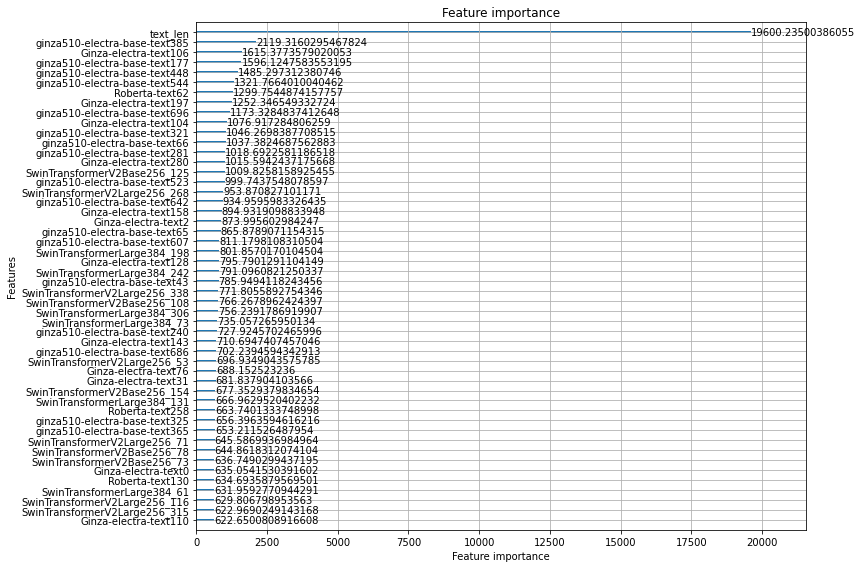

In [39]:
# 特徴量の重要度を可視化。
lgb.plot_importance(lgb_clf, figsize=(12,8), max_num_features=50, importance_type='gain')
plt.tight_layout()
plt.show()

In [40]:
# 評価指標はlog lossだが、accuracyも見てみる

val_pred = lgb_clf.predict(valid_x, num_iteration=lgb_clf.best_iteration)
val_pred_max = np.round(lgb_clf.predict(valid_x)).astype(int)  # クラスに分類
accuracy = sum(valid_y == val_pred_max) / len(valid_y)
print(accuracy)

0.6302823953534948



default
0.6214700580813138
d lr 0.01 depth9
0.6328860404566393

Text(0.5, 51.0, 'Predict')

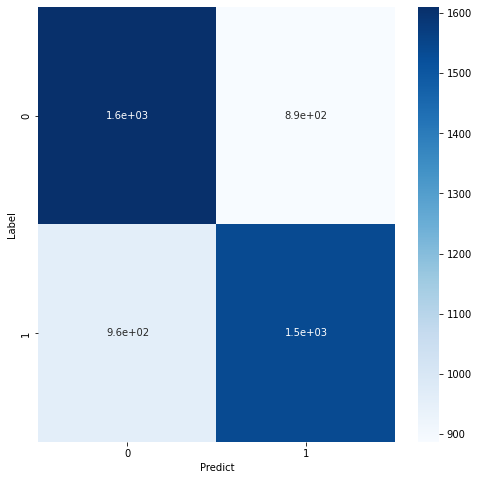

In [41]:
_conf_options = {"normalize": None,}
_plot_options = {
        "cmap": "Blues",
        "annot": True
    }

conf = confusion_matrix(y_true=valid_y,
                        y_pred=val_pred_max,
                        **_conf_options)

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf, ax=ax, **_plot_options)
ax.set_ylabel("Label")
ax.set_xlabel("Predict")

# Predict

In [42]:
test_pred = lgb_clf.predict(test_x, num_iteration=lgb_clf.best_iteration)

In [43]:
submission_df["is_laugh"] = test_pred
submission_df.head()

,id,is_laugh
0,rfdjcfsqq,0.465583
1,tsgqmfpef,0.412966
2,owjcthkz2,0.300154
3,rvgaocjyy,0.421850
4,uxtwu5i69,0.825842


In [44]:
submission_df.to_csv(('sub.csv'), index=False)

実際に提出して、スコアを確認してみましょう。  精度向上に向けて様々なアイディアがあるかと思いますので、ぜひいろいろとトライしていただければと思います！

- 異なる学習済みモデルでの特徴量化
- 画像の状況とボケての文章との解離具合を測定する
- 説明文口調とセリフ口調の分類をしてみる。
- 画像に何が写っているかを検出し、特徴量に加えてみる（人が写っている。動物が写っている）


https://lab.mo-t.com/blog/kaggle-shopee
前処理については今回は気にしない。最終的なLightgbmにぶっこむ特徴量を増やして選別する方針でいく。
エンベッディングした結果は保存する。
最初は画像は画像、テキストはテキストでエンベッディングする。
画像のArcFaceちょっとめんどい、実装できそうならやる
knn(k=50)を使って、画像、テキストの分類自体はする。
https://www.kaggle.com/code/jyotmakadiya/shopee-groupkfolds-effnetb1-and-tfidf-or-bert

基本はエンベッディングしたものを使う。
プラスで、特徴量を足してみる。
乖離具合ってどうやって測定するのか
・長文？なんかキーになる話がある？画像と関係？わからん
・ボケのデザインパターン/ジョナサン・ハイト
・既知未知判定ってどうやってやるんだ・・・
・ポジネガ距離はおもろい。
あえて正しいこととは逆なことをして、許されるライン的な話。
→単純にえぐい言葉やえぐさを分類？なんかいいのないかな。
説明文とセリフ文→なんかいい楽な分類ないかな、なかったら頑張る。
画像に何が写っているか→うーん、手動しかないかも。